/tmp/ipykernel_129126/2365326227.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('runs/generator.pt', map_location=device))


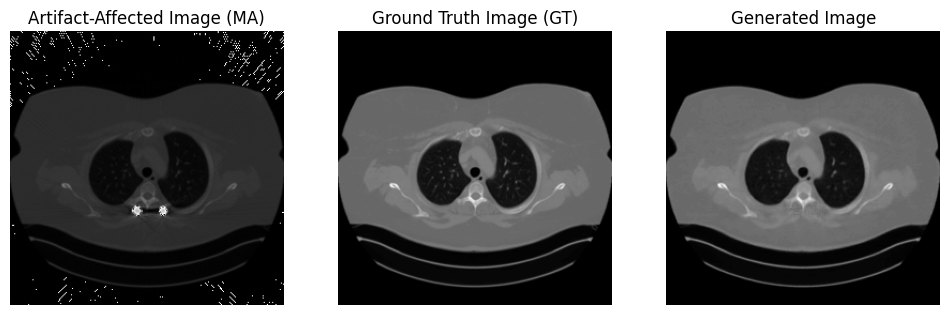

In [4]:
import torch
import h5py
import matplotlib.pyplot as plt
from torchvision import transforms
from generator import UnetGenerator  # Assuming the generator architecture is in generator.py
from PIL import Image

# Set the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the trained generator model
generator = UnetGenerator().to(device)
generator.load_state_dict(torch.load('runs/generator.pt', map_location=device, weights_only=True))
generator.eval()  # Set model to evaluation mode

# Transformation to match training preprocessing (e.g., normalization)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Inverse transform for visualization (to undo normalization)
inverse_transform = transforms.Compose([
    transforms.Normalize(mean=[-1], std=[2]),  # Reverse normalization if mean=0.5, std=0.5
    transforms.ToPILImage()
])

# Load and process the .h5 data file
def process_h5_file(file_path):
    with h5py.File(file_path, 'r') as f:
        ma_image = f['ma_CT'][:]  # Artifact-affected image as a NumPy array
        gt_image = f['image'][:]  # Ground truth image as a NumPy array

    # Convert the NumPy arrays to PIL images
    ma_image = Image.fromarray(ma_image)
    gt_image = Image.fromarray(gt_image)

    # Apply transformations
    ma_tensor = transform(ma_image).unsqueeze(0).to(device)  # Add batch dimension and move to device
    gt_tensor = transform(gt_image).unsqueeze(0).to(device)  # Add batch dimension and move to device
    
    # Generate the cleaned image
    with torch.no_grad():
        generated_tensor = generator(ma_tensor)

    # Remove batch dimension and apply inverse transform for visualization
    ma_image = inverse_transform(ma_tensor.squeeze(0).cpu())
    gt_image = inverse_transform(gt_tensor.squeeze(0).cpu())
    generated_image = inverse_transform(generated_tensor.squeeze(0).cpu())

    return ma_image, gt_image, generated_image

# Visualization function
def visualize_images(ma_image, gt_image, generated_image):
    plt.figure(figsize=(12, 4))
    
    # Plot artifact-affected image
    plt.subplot(1, 3, 1)
    plt.imshow(ma_image, cmap="gray")
    plt.title("Artifact-Affected Image (MA)")
    plt.axis("off")

    # Plot ground truth image
    plt.subplot(1, 3, 2)
    plt.imshow(gt_image, cmap="gray")
    plt.title("Ground Truth Image (GT)")
    plt.axis("off")

    # Plot generated image
    plt.subplot(1, 3, 3)
    plt.imshow(generated_image, cmap="gray")
    plt.title("Generated Image")
    plt.axis("off")

    plt.show()

# Path to the .h5 file
h5_file_path = "/home/maya/train_640reduced/000086_03_01/018/0.h5"  # Replace with the path to your .h5 file

# Process and visualize
ma_image, gt_image, generated_image = process_h5_file(h5_file_path)
visualize_images(ma_image, gt_image, generated_image)